# Try GRASS GIS in Jupyter Notebook with Python

[<img src="grass_gis_logo.png" alt="GRASS GIS" style="width:200px;"/>](https://grass.osgeo.org/)

This is a quick introduction into *GRASS GIS* in a *Jupyter Notebook* using the *Python* scripting language.
The interactive notebook is available online thanks to the [*Binder*](https://mybinder.org/) service.

In this notebook, we create watersheds from an elevation raster then compute zonal statistics for elevation and slope. We use a sample GRASS GIS dataset for North Carolina, USA. The dataset is included in this environment.

## Usage

To run the selected part which is called a cell, hit `Shift + Enter`.

## Start

There is several ways how GRASS GIS can be used. When using Python in notebook, we usually find GRASS GIS Python packages, import them, initialize GRASS GIS session, and set several variables useful for using GRASS GIS in a notebook.

In [3]:
# Import Python standard library and IPython packages we need.
import os
import sys
import subprocess
import csv
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# show matplotlib outputs automatically in the notebook
%matplotlib inline

# Ask GRASS GIS where its Python packages are.
gisbase = subprocess.check_output(["grass", "--config", "path"], text=True).strip()
os.environ['GISBASE'] = gisbase
sys.path.append(os.path.join(gisbase, "etc", "python"))

# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.script.setup as gsetup

# Create a GRASS GIS session.
rcfile = gsetup.init(gisbase, "data/grassdata", "nc_basic_spm_grass7", "user1")

# We want functions to raise exceptions and see standard output of the modules in the notebook.
gs.set_raise_on_error(True)
gs.set_capture_stderr(True)
# Simply overwrite existing maps like we overwrite Python variable values.
os.environ['GRASS_OVERWRITE'] = '1'
# Enable map rendering in a notebook.
os.environ['GRASS_FONT'] = 'sans'
# Set display modules to render into a file (named map.png by default).
os.environ['GRASS_RENDER_IMMEDIATE'] = 'cairo'
os.environ['GRASS_RENDER_FILE_READ'] = 'TRUE'
os.environ['GRASS_LEGEND_FILE'] = 'legend.txt'

## Computing Watersheds

Now that we have GRASS GIS running in our notebook, let's try some basic commands. 

In this section, we create watersheds from elevation. First, we set computational region and create an elevation map from the sample GRASS GIS dataset for North Carolina, USA.

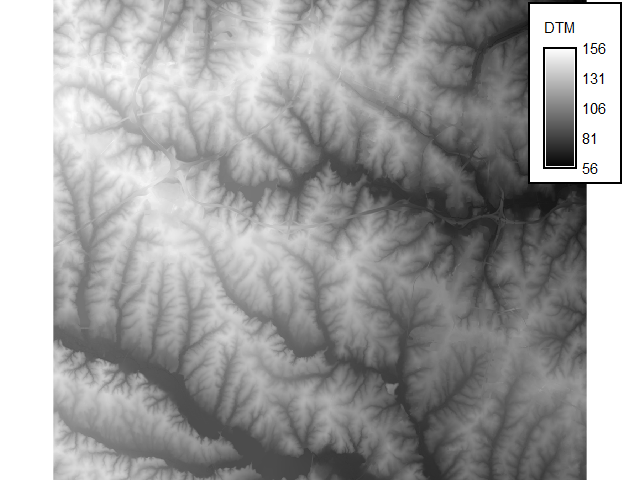

In [4]:

# Set computational region to the study area.
gs.parse_command('g.region', raster="elevation", flags='pg')
# Draw elevation (DTM) to get an overview of the area.
gs.run_command('r.colors', map="elevation", color="elevation")
gs.run_command('d.erase')
gs.run_command('d.rast', map="elevation")
gs.run_command('d.legend', raster="elevation", at=(65, 90, 85, 90), fontsize=15, flags="b", title="DTM")
Image(filename="map.png")

From the elevation raster, we compute the watersheds and display the results. 

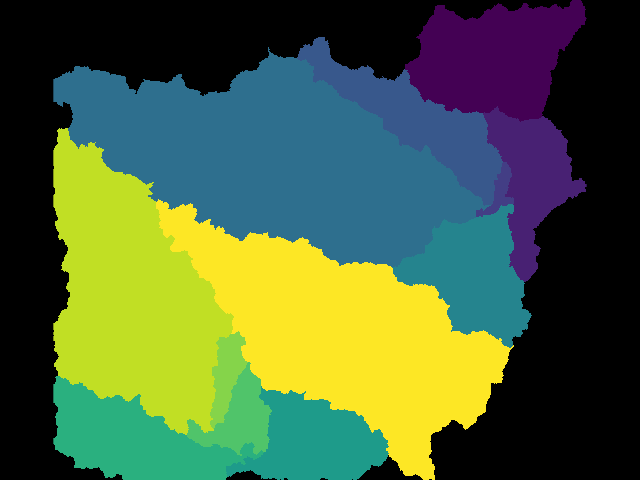

In [5]:
# Determine watersheds.
gs.run_command("r.watershed", elevation="elevation", basin="watersheds", threshold=80000)
# View them.
gs.run_command("r.colors", map="watersheds", color="viridis")
gs.run_command('d.erase', background="black")
gs.run_command('d.rast', map="watersheds")
Image(filename="map.png")

## Creating a Choropleth Map of Watershed Area

With our watersheds, we can compute some zonal statistics. In this section, we use the `"count"` method in `r.stats.zonal` to make a map of watershed area.

The output of `r.stats.zonal` is a raster so we can make nice maps of our zonal statistics.

In [6]:
gs.run_command("r.stats.zonal", base="watersheds", cover="elevation", method="count", output="watersheds_count")

Convert cell count to area by multiplying by cell size (N-S resolution * E-W resolution) and convert to square kilometers.

In [7]:
# Get projection resolution
proj = gs.parse_command("g.region", flags="m")

# Multiply N-S resolution by E-W resolution to get cell area
cell_area = float(proj['nsres'])*float(proj['ewres'])

# Calculate watershed areas and convert from m2 to km2
gs.mapcalc("'watersheds_area' = float('watersheds_count'*{})/1000000".format(cell_area))

Display map of watershed areas.

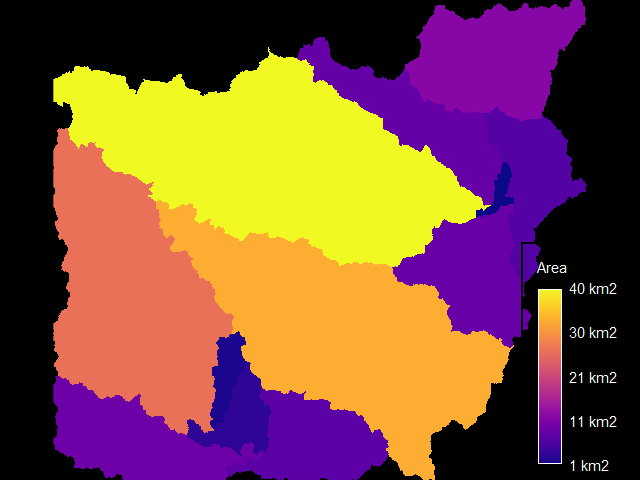

In [8]:
gs.run_command("r.colors", map="watersheds_area", color="plasma")
gs.run_command('d.erase', background="black")
gs.run_command('d.rast', map="watersheds_area")
gs.run_command('d.legend', raster="watersheds_area", bgcolor="none", color="white", border_color="none",
               at=(3, 40, 84, 88), lines=2, fontsize=15, title="Area", units=" km2")
Image(filename="map.png")

## Slope Zonal Statistics
In addition to their elevations, we might also be interested the slope within our watersheds.

Begin by computing and displaying slope from the elevation raster.

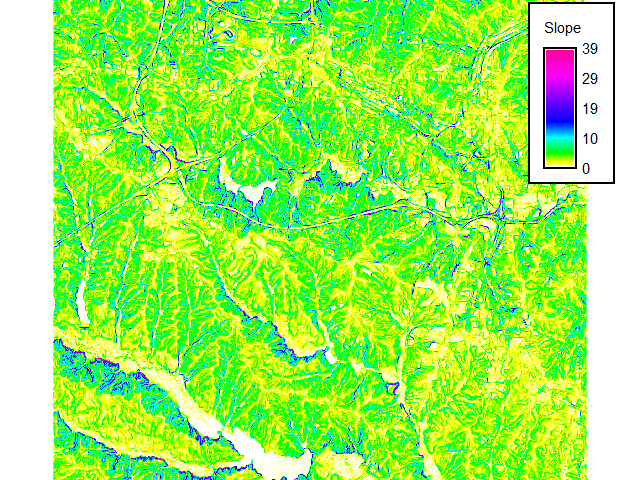

In [9]:
# Compute Slope
gs.run_command("r.slope.aspect", elevation="elevation", slope="slope")
# Display slope map
gs.run_command('d.erase')
gs.run_command('d.rast', map="slope")
gs.run_command('d.legend', raster="slope", at=(65, 90, 85, 90), fontsize=15, flags="b", title="Slope", units="°")
Image(filename="map.png")

Use `r.stats.zonal` to compute the average slope in each watershed.

In [10]:
gs.run_command("r.stats.zonal", base="watersheds", cover="slope", method="average", output="watersheds_slope_avg")

Display the resulting map.

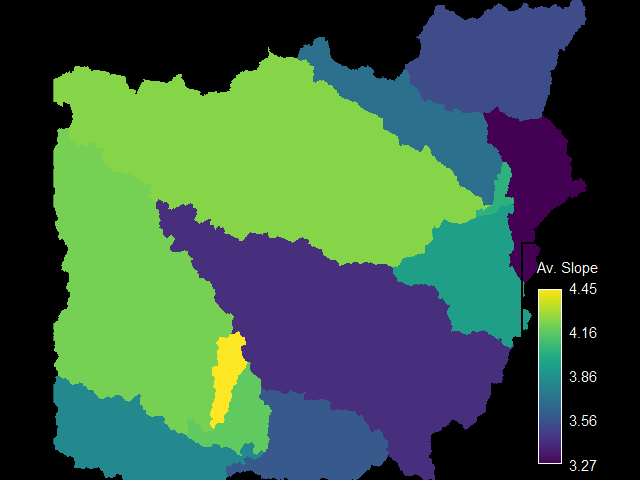

In [11]:
gs.run_command("r.colors", map="watersheds_slope_avg", color="viridis")
gs.run_command('d.erase', background="black")
gs.run_command('d.rast', map="watersheds_slope_avg")
gs.run_command('d.legend', raster="watersheds_slope_avg",bgcolor="none", color="white", border_color="none",
               at=(3, 40, 84, 88), lines=2, fontsize=15, title="Av. Slope")
Image(filename="map.png")

## Converting to Vectors

Convert watersheds with average slope from raster to vector to make a nice map.

In [12]:
gs.run_command("r.to.vect", flags="s", input="watersheds_slope_avg", output="watersheds_vector", type="area")

Overlay outline of watershed on elevation map.

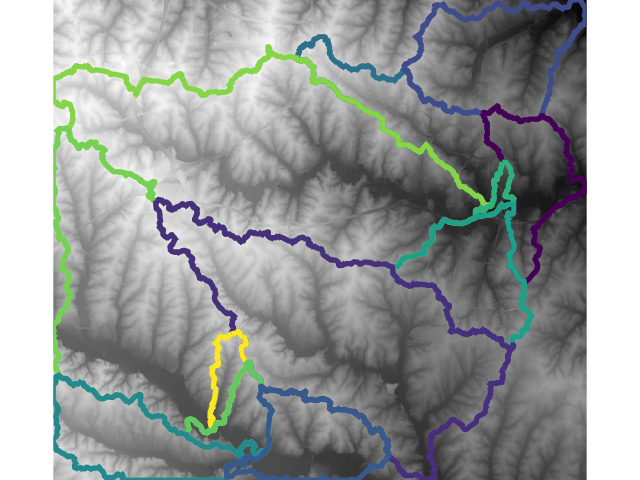

In [13]:
# Set Colors
gs.run_command("v.colors", map="watersheds_vector", use="attr", column="value", color="viridis")
gs.run_command("r.colors", map="elevation", color="grey")

#Display
gs.run_command('d.erase')
gs.run_command('d.rast', map="elevation")
gs.run_command('d.vect', map="watersheds_vector", fill_color="none", width=5)
Image(filename="map.png")

## Zonal statistics as a Table
As an alternative to `r.stats.zonal`, we can use `r.univar` which returns a table of univariate statistics instead of a raster. In this section, we compute average slope and standard deviation in each watershed then make a bar plot to compare them. Each watershed is a zone.

We start by getting the univariate zonal statistics of elevtation as a CSV.

In [14]:
separator = "|"

columns = defaultdict(list) # each value in each column is appended to a list

text = gs.read_command("r.univar", map="elevation", zones="watersheds", separator=separator, flags="t")
reader = csv.DictReader(text.splitlines(), delimiter=separator)
for row in reader: # read a row as {column1: value1, column2: value2,...}
    for (k,v) in row.items(): # go over each column name and value 
        columns[k].append(v) # append the value into the appropriate list
                             # based on column name k

watersheds = columns['zone']
means = np.array(columns['mean'], dtype=np.float32)
stddevs = np.array(columns['stddev'], dtype=np.float32)

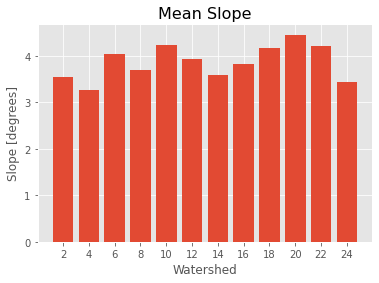

In [15]:
bar_positions = np.arange(len(watersheds))
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.set_title("Mean Slope", fontsize=16)
ax.set_xlabel("Watershed")
ax.set_ylabel("Slope [degrees]")
ax.bar(bar_positions, means)
ax.set_xticks(bar_positions)
ax.set_xticklabels(watersheds)
plt.show()